# **Loading the Data for Named Entity Recognition (NER)**

In [1]:
import pandas as pd
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In the data, we can see that the words are broken into columns which will represent our feature X, and the Tag column in the right will represent our label Y.

# **Data Preparation for Neural Networks**

I will train a Neural Network for the task of Named Entity Recognition (NER). So we need to do some modifications in the data to prepare it in such a manner so that it can easily fit into a neutral network. I will start this step by extracting the mappings that are required to train the neural network:

In [2]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

Now I will transform the columns in the data to extract the sequential data for our neural network:

In [4]:
# Map Word and Tag to their respective indices
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

# Fill missing values in the DataFrame
data_fillna = data.fillna(method='ffill')

# Group by sentence and aggregate the necessary columns as lists
data_group = data_fillna.groupby('Sentence #', as_index=False).agg({
    'Word': list,
    'POS': list,
    'Tag': list,
    'Word_idx': list,
    'Tag_idx': list
})


/tmp/ipython-input-4-2035088178.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill')


Now I will split the data into training and test sets. I will create a function for splitting the data because the LSTM layers accept sequences of the same length only. So every sentence that appears as integer in the data must be padded with the same length:

In [5]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )

    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


# **Training Neural Network for Named Entity Recognition (NER)**

Now, I will proceed with training the neural network architecture of our model. So let’s start with importing all the packages we need for training our neural network:

In [6]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

The layer below will take the dimensions from the LSTM layer and will give the maximum length and maximum tags as an output:

In [7]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

Now I will create a helper function which will help us in giving the summary of every layer of the neural network model for Named Entity Recognition (NER):

In [8]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

Now I will create a helper function to train the Named Entity Recognition model:

In [9]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

Driver code:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 17)         │         1,105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,429,329 (5.45 MB)

 Trainable params: 1,429,329 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

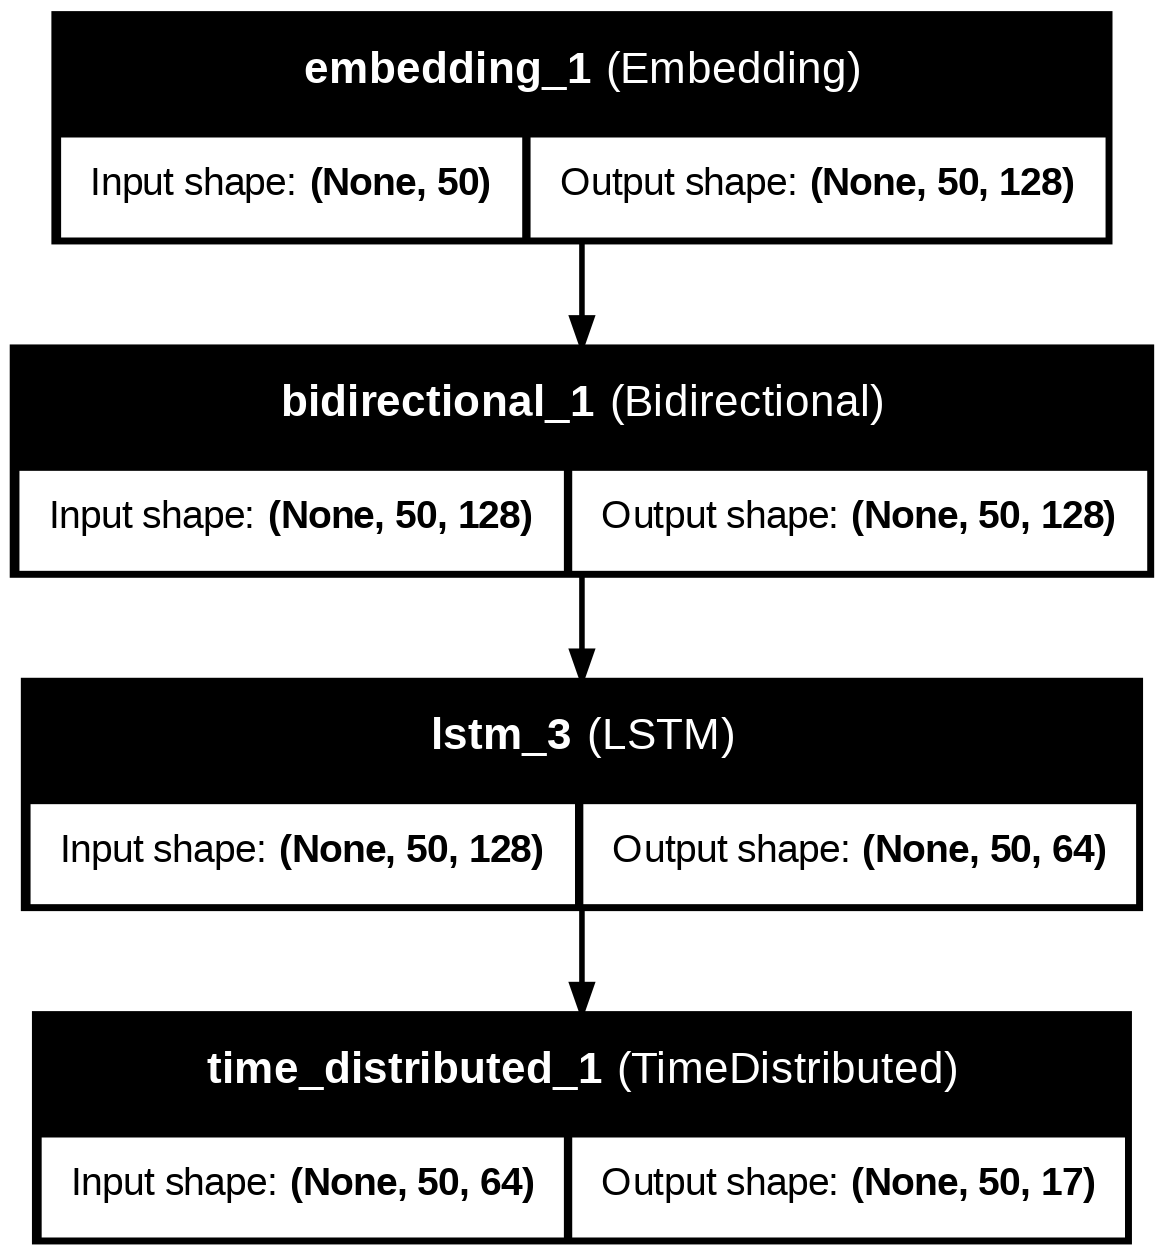

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.utils import plot_model

# Sample config – adjust according to your dataset
VOCAB_SIZE = 10000         # Total unique tokens in your dataset
EMBEDDING_DIM = 128        # Embedding vector size
MAX_SEQ_LEN = 50           # Max sentence length (padded)
NUM_TAGS = 17              # Number of unique tags (like B-LOC, I-ORG, O, etc.)

# Define the BiLSTM + LSTM model
def get_bilstm_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM))  # Removed deprecated input_length
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(TimeDistributed(Dense(NUM_TAGS, activation='softmax')))
    return model

# Instantiate model
model_bilstm_lstm = get_bilstm_lstm_model()

# Build the model by providing input shape (excluding batch size)
model_bilstm_lstm.build(input_shape=(None, MAX_SEQ_LEN))  # Builds model with (batch_size, seq_len)

# Show model architecture
model_bilstm_lstm.summary()

# Plot model (Google Colab will show it inline)
plot_model(model_bilstm_lstm, show_shapes=True, show_layer_names=True)


The model will give the final output after running for 25 epochs. So it will take some time to run.

# **Testing the Named Entity Recognition (NER) Model:**

In [13]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Hi, My name is E S Nishant \n I am from India \n I want to work with Google \n Sundar Pichai is My Inspiration')
displacy.render(text, style = 'ent', jupyter=True)

So we can see a very good result from our model.